## Allen-Cahn System Solver Result Summary (1D)

**Woojeong Kim** *8/12/2025*

    

## Overview
- Purpose : PINN PDE solver modeling and result error computing
- Experiments to compare sampling methodologies:  
                1. Baseline PINN experiment as default  
                2. Loss - adaptive PINN experiment  
                3. Energy - adaptive PINN experiment
- Neural network structure: In this notebook we use 6 hidden layers with neuron size 128 for the `forward` pass of the neural network and `torch.tanh`activation function on each layer.

### Allen-Cahn system
The **Allen-Cahn equation** is the basic phase separation and interface dynamics. In our examples, there is phase indicator variable $u$ on [-1,1] and we capture the track of the interface of two different phases of $u = 1$ and $u= -1$. The system has the form on 1-dimensional domain:
$$
\frac{\partial u(x,t)}{\partial t} = \gamma_1 u_{xx}(x,t)- \gamma_2 (u^3(x,t) - u(x,t)), \text{~ where ~} m > 0 \text{~and~} x \in \Omega.
$$
Main driving force of this equation is Energy term - i.e, the output solution variable $u$ behaves mainly by **Energy** of the form:
$$
E(u) = \int_{\Omega} \gamma_2 (u^2(x,t)- 1)^2 - \frac{\gamma_1}{2} u_{x}^2(x,t) du
$$

### Existence of exact solution
Theoretically, there is no exact solution which depends on $x$ and $t$. Since there is only exact solution formula depending on $x$, we use the FD solver and its solution for measuring the accuracy of PINN output solution. The below figure is made by this FD solution as exact solution of this AC system.
<table>
  <tr>
    <td align="center">
      <img src="Base_g4/exact_solution_g4.png" width="750"/><br/>
      <small>Figure 1.2: Energy adaptive</small>
    </td>
  </tr>
</table>

### Physics-Informed Neural Network Loss Term
As the preliminary famework for building PINN, we use the following loss terms to optimize total loss by `.backward()` at the end of each training iteration. The 1-dimensional spatial domain $\Omega := [-1, 1]$ and time domain is $[0,T]$ where $T$ is ending time.
- Loss on domain with sampled collocation points $(x_1, t_1), (x_2, t_2), ..., (x_{12000},t_{12000})$
  $$
  L_{p} = \sum_{i=1}^{12000}\frac{1}{12000}(u(x_i,t_i)_t - \gamma_1 u_{xx}(x_i,t_i) + \gamma_2 (u^3(x_i,t_i) - u(x_i,t_i)))^2, ~~~~ (x_i,t_i) \in [-1, 1] \times [0, T]
  $$
- Loss derived from initial condition with sampled collocation points $x_1, x_2, ..., x_{200}$
  $$
  L_i = \sum_{i=1}^{200}\frac{1}{200}(u(x_i,t_i) -u_0(x,0))^2,  ~~~~ x \in [-1, 1]
  $$
  where $u_0 = u(x, 0)$ is given as specific initial condition.
- Loss derived from boundary condition - periodic boundary -  with sampled collocation points $t_1, t_2, ..., x_{150}$
  $$
  L_{b1} = \sum_{i=1}^{150}\frac{1}{150}(u(-1,t_i) - u(1,t_i))^2
  $$
  $$
  {L}_{b2} = \sum_{i=1}^{150}\frac{1}{150}(u_x(-1,t_i) - u_x(1,t_i))^2,  ~~~~ t \in [0, T]
  $$
And, the basic total loss is set as follows.
$$
\implies L_t = L_{p} + 1000 L_i + L_{b1} + L_{b2}
$$

### Experiment 1 : Base PINN without adaptive sampling
This is the base line experiment using the basic total loss $L_t$. As mentioned above, we use 6 hidden layers with neuron size 128 for the `forward` pass of the neural network and `torch.tanh`activation function on each layer. In this experiment, 12000, 150 and 200 collocation points collocation points were used for computing $L_p$, $L_{b1}+{L}_{b2}$ and $L_i$ respectively.


### Experiment 2 : PINN with loss-adaptive sampling
This is the classical experiment for observing the efficiency of adaptive resampling. we splited the basic total loss $L_t$ into the basic loss term and resampled loss term according to the upper 10% high-loss points:
$$
\implies L_t = L_{p1} + L_{p2} + 1000 (L_{i1} + L_{i2}) + L_{b1} + L_{b2}
$$
where $L_{p1} = L_{p}$, $L_{i1} = L_{i}$. And, $L_{p2}$, $L_{i2}$ are pde loss term and initial loss term from the high-loss resampling for the upper 10% from each term. The collocation points numbers are 8000 for $L_{p1}$, 4000 for $L_{p2}$, 150 for $L_{i1}$, 50 for $L_{i2}$ and 150 for $L_{b1} + L_{b2}$.

### Experiment 3 : PINN with Energy-adaptive sampling
This is the new resampling method in MCMC(Markov chain Monte Carlo) process, **likelihood-free MCMC**, which is inspired by Metropolis Hasting and probability density approximation to the gradient of eneery $\frac{\partial E}{\partial x}$. By employing this method, we give more training collocation points on the rapidley changing domain area powered by fast change of energy value. Similar to the Experiment2, to compare this with the previous experiment, we splited the basic total loss $L_t$ in experiment 1 into the basic loss term and loss term resampled from this likelihood-free MCMC:
$$
\implies L_t = L_{p1} + 100L_{p3} + 1000 (L_{i1} + L_{i3}) + L_{b1} + L_{b2}
$$
where $L_{p1} = L_{p}$, $L_{i1} = L_{i}$. And, $L_{p3}$, $L_{i3}$ are pde loss term and initial loss term from the likelihood-free MCMC. The collocation points numbers are 8000 for $L_{p1}$, 4000 for $L_{p3}$, 150 for $L_{i1}$, 50 for $L_{i3}$ and 150 for $L_{b1} + L_{b2}$.

### Algorithm: Likelihood-Free MCMC(LF Metropolis-Hastings) sampling

We are given data $\theta = {\theta_1, \theta_2, ..., \theta_n}$ as status of coordinate on domain. By using them, derive $x = {x_1, x_2, ..., x_n}$ which are the scaled energy of the status. We assume that the likelihood of $\theta$ is represented as energy of neighborhood points for each of $\theta$. In this context, we will accept or reject proposal $(\theta', x')$ by using acceptance ratio $\alpha$ where $\theta' = {\theta_1', \theta_2', ..., \theta_n'}$. Since $\theta :=  From the current algorithm sate $(\theta, x)$, a new parameter vetor $\theta '$ is drawn from a proposal distribution $q(\theta ' | \theta)$.

**Input**:  
- Target distribution $\pi(\theta, t) \propto E(\theta,t) \approx \pi(\theta, t)$  
- Proposal distribution $q(x' | x) ~ N(\pi(x,t), 0.075)$  
- Initial value $x_0 := \pi (\theta,0)$  
- Total number of approximating sampling iterations $N := 75$

**Output**:  
- Samples $\hat{\theta} = {\hat{\theta}_1, \hat{\theta}_2, ..., \hat{\theta}_n}$ approximating $\pi(\theta, t)$

**Steps**:

1. Initialize k = 1 and observed data y  ← $\pi( B )$ for i = 1,2,...,n where B := {100 points in the closed disk centered $\theta$ with radius 0.25}.  
2. For step $k$ with given $(\theta_{k},x_{k}) = (\theta,x)$:
    - (1) Extract generalized simulation data $x_i$ ←  $\pi( B )$ for i = 1,2,...,n where B := {100 points in the closed disk centered $\theta_i$ with radius 0.25}.  
    - (2) Generate $\theta'$ ∼ $q( \theta' | \theta)$
    - (3) Similar to (1), generate generalized simulation data $x_i'$ ← $\pi( B' )$ for i = 1,2,...,n where B' := {100 points in the closed disk centered $\theta_i'$ with radius 0.25}.
    - (4) Compute acceptance ratio:  
      $$ \alpha = \min\left(1, \frac{\pi_{\epsilon}(y|x', \theta') \pi(\theta')q(\theta | \theta')}{\pi_{\epsilon}(y|x, \theta) \pi(\theta)q(\theta' | \theta)}\right), $$
      given
      $$
      \pi_{\epsilon}(y|x, \theta) = 1 if |\text{RBF}(y, x)| < \epsilon,  
      =0 otherwise
      $$
      where RBF() computes Gaussian kernel similarity (RBF similarity) for 100 neighborhood points B' of the query $\theta'$. against 100 neighborhood points B of the query $\theta$.
    - (5) With probability $\alpha$, accept $(\theta_{k+1},x_{k+1}) = (\theta', x')$ ; else, keep $(\theta,x)$.
3. Increment $k = k+1$ and go to 2. until $k = 75$.


# Net load and graphing

## Case 1. $\gamma_1 = 0.0001$ and $\gamma_2 = 4$
### Resampling Figures for each end time

# 2 different figures from loss-adaptive(experiment2) and Energy-adaptive(experiment3) sampling
<table>
  <tr>
    <td align="center">
      <img src="Loss_adaptive_g4/2by10_adap.png" width="750"/><br/>
      <small>Figure 2: Loss adaptive</small>
    </td>
    <td align="center">
      <img src="Energy_adaptive_g4/2by10_adap.png" width="750"/><br/>
      <small>Figure 3: Energy adaptive</small>
    </td>
  </tr>
</table>

### Error Plot Results

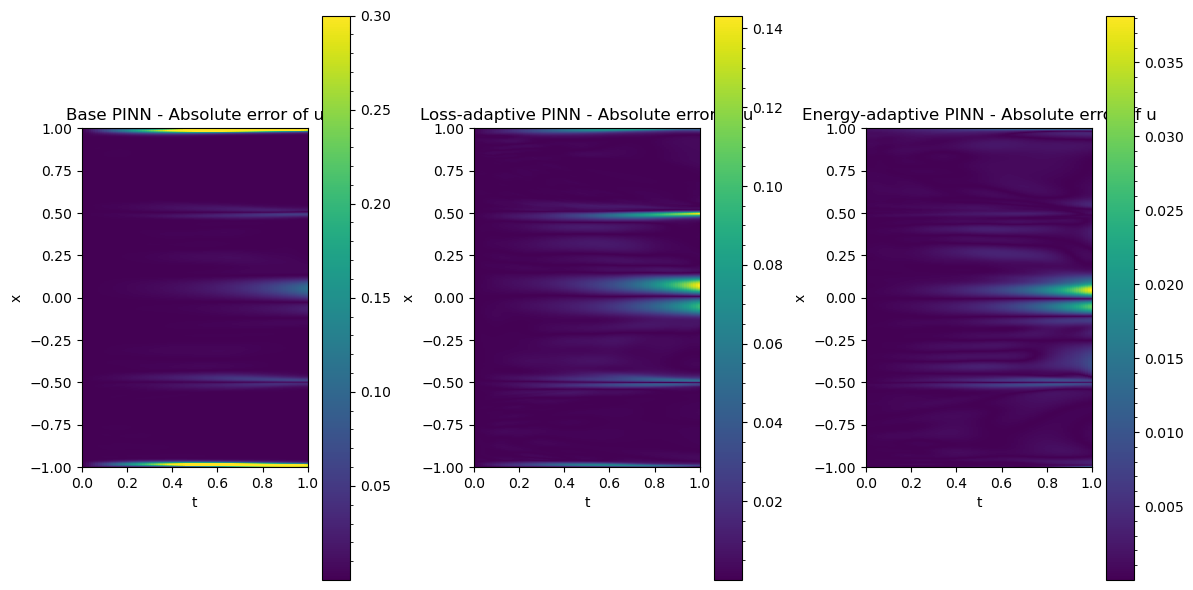

/var/folders/j9/4s8713nn53v3jz3ky1rz1f6h0000gn/T/ipykernel_44122/2768054295.py:146: UserWarning: The figure layout has changed to tight
  fig.tight_layout()


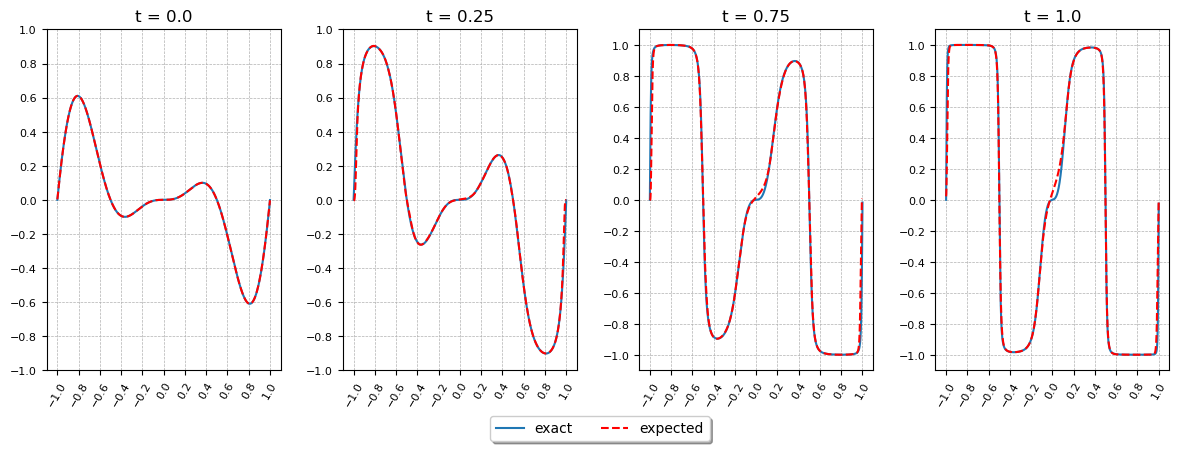

<Figure size 1000x600 with 0 Axes>

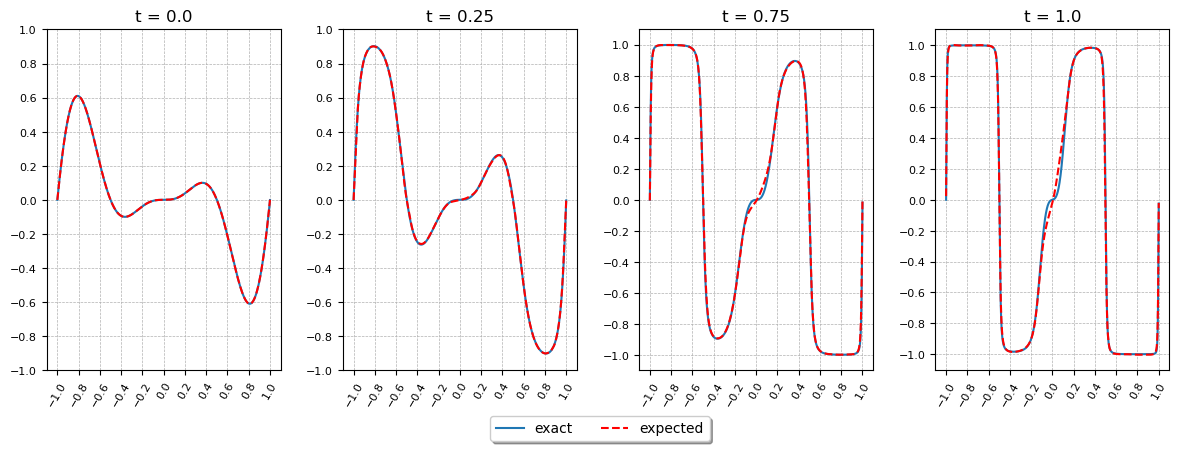

<Figure size 1000x600 with 0 Axes>

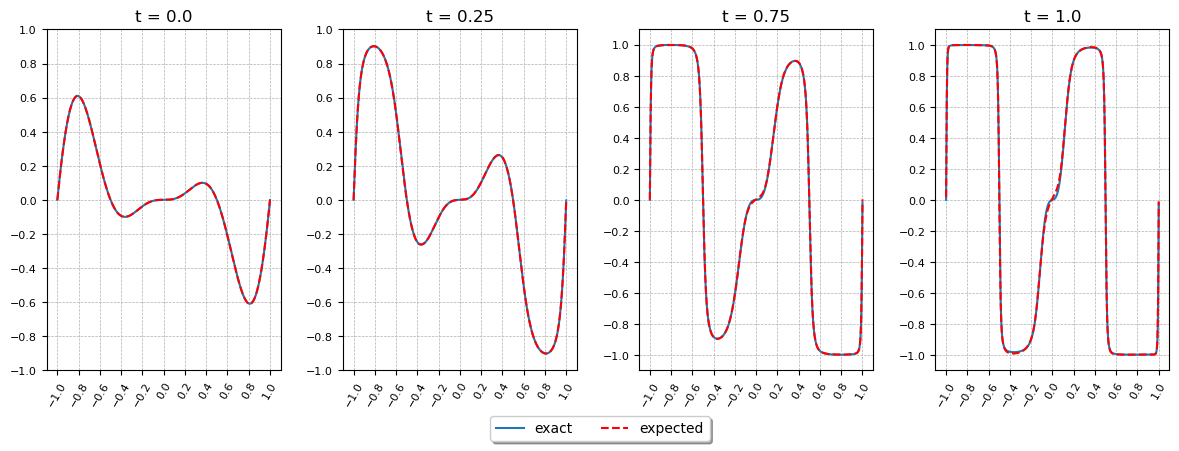

<Figure size 1000x600 with 0 Axes>

In [27]:
import torch
from torch import nn
import numpy as np
from torch.autograd import Variable
import matplotlib.pyplot as plt
from Building_Net import Net
from AC1Dnet import AC1Dnet
from AC1Dnet2 import AC1Dnet2
import os
from datetime import datetime
from IPython.display import display, HTML

# Set timestamp for figure output
currentDateTime = datetime.now()
ctime = f"{currentDateTime.month}_{currentDateTime.day}_{currentDateTime.hour}h"

# Finite Difference data load
data = np.load("Energy_adaptive_g4/u_exact.npz")
u_list = data['u_list']

# Base PINN network = net1
net1 = AC1Dnet([2, 128, 128, 128, 128, 128, 128, 1])
net2 = AC1Dnet2([2, 128, 128, 128, 128, 128, 128, 1])
net3 = Net()
net1.load_state_dict(torch.load("Base_g4/CH_Benchmarks_Pass_1.pt", map_location=torch.device('cpu')))

# Loss-adaptive PINN network = net2
net2.load_state_dict(torch.load("Loss_adaptive_g4/final_time_1.0_0.9.pt", map_location=torch.device('cpu')))

# Energy-adaptive PINN network = net3
net3.load_state_dict(torch.load("Energy_adaptive_g4/8_7_18h_Training_5.pt", map_location=torch.device('cpu')))

#--------------------------------------------------------------
end_time = 1
#--------------------------------------------------------------
# Parameters
Nx = int(2e6)
dlta_x = 200
delta_t = 1e-4
total_step_x = int(Nx / dlta_x)
total_step_t = int(1 +100*end_time)


# Define evaluation grid: x (space), t (time)
x = np.linspace(net1.x1_l, net1.x1_u, total_step_x, endpoint=True)
t = np.linspace(0, end_time, total_step_t, endpoint=True)
t_grid, x_grid = np.meshgrid(t, x)  # shape: (x, t)

# Prepare input tensors
x_input = x_grid.reshape(-1, 1)
t_input = t_grid.reshape(-1, 1)
pt_x = Variable(torch.from_numpy(x_input).float(), requires_grad=True)
pt_t = Variable(torch.from_numpy(t_input).float(), requires_grad=True)

# Predict output from the net1, net2, net3
u_1 = net1(pt_x, pt_t)
u_1 = u_1.data.cpu().numpy().reshape(total_step_x, total_step_t)  # shape (x, t)

u_2 = net2(pt_x, pt_t)
u_2 = u_2.data.cpu().numpy().reshape(total_step_x, total_step_t)

u_3 = net3(pt_x, pt_t)
u_3 = u_3.data.cpu().numpy().reshape(total_step_x, total_step_t)

u_predict = [u_1, u_2, u_3]
# Load exact solution from Finite Difference data u_list
sampled_u = []
for t_idx in range(total_step_t):
    sampled_u.append(u_list[t_idx][::dlta_x])  # every 200th spatial point
sampled_u = np.array(sampled_u).T  # shape (x, t)

# Absolute errors from the net1, net2, net3
u_ab_err1 = np.abs(u_1 - sampled_u)
u_ab_err2 = np.abs(u_2 - sampled_u)
u_ab_err3 = np.abs(u_3 - sampled_u)

# Plot
fig, axs = plt.subplots(1, 3, figsize=(12, 6))
aspect_ratio = end_time / (net1.x1_u - net1.x1_l)

# net1 Absolute error plot
mapping0 = axs[0].imshow(u_ab_err1, vmax = 0.3,
                         interpolation='none',
                         extent=(0, end_time, net1.x1_l, net1.x1_u),
                         origin='lower', aspect=end_time/2 *1.5)
axs[0].set_title('Base PINN - Absolute error of u')
axs[0].set_xlabel('t')
axs[0].set_ylabel('x')
cbar0 = fig.colorbar(mapping0, ax=axs[0])
cbar0.minorticks_on()

# net2 Absolute error plot
mapping1 = axs[1].imshow(u_ab_err2,
                         interpolation='none', 
                         extent=(0, end_time, net1.x1_l, net1.x1_u),
                         origin='lower', aspect=end_time/2 *1.5) ####vmax = .1,
axs[1].set_title('Loss-adaptive PINN - Absolute error of u')
axs[1].set_xlabel('t')
axs[1].set_ylabel('x')
cbar1 = fig.colorbar(mapping1, ax=axs[1])
cbar1.minorticks_on()

# net2 Absolute error plot
mapping1 = axs[2].imshow(u_ab_err3,
                         interpolation='none', 
                         extent=(0, end_time, net1.x1_l, net1.x1_u),
                         origin='lower', aspect=end_time/2 *1.5) ####vmax = .1,
axs[2].set_title('Energy-adaptive PINN - Absolute error of u')
axs[2].set_xlabel('t')
axs[2].set_ylabel('x')
cbar1 = fig.colorbar(mapping1, ax=axs[2])
cbar1.minorticks_on()

plt.tight_layout()
plt.show()
fig.savefig(f"3D_absolute_error.png")
#************************************************ sliced graphs *******************************************************#

t1 = 0*end_time*np.ones((total_step_x,1))
t2 = 0.25*end_time*np.ones((total_step_x,1))
t3 = 0.75*end_time*np.ones((total_step_x,1))
t4 = end_time*np.ones((total_step_x,1))

#convert to pytorch tensors
pt_x_ = Variable(torch.from_numpy(x).float(), requires_grad=True).reshape(-1,1) #.to(device)
#pt_x2 = Variable(torch.from_numpy(x2).float(), requires_grad=True) #.to(device)

pt_t1 = Variable(torch.from_numpy(t1).float(), requires_grad=True).reshape(-1,1) #.to(device)
pt_t2 = Variable(torch.from_numpy(t2).float(), requires_grad=True).reshape(-1,1) #.to(device)
pt_t3 = Variable(torch.from_numpy(t3).float(), requires_grad=True).reshape(-1,1) #.to(device)
pt_t4 = Variable(torch.from_numpy(t4).float(), requires_grad=True).reshape(-1,1) #.to(device)

def sliced_plot_2D(net):
    #get network outputs
    u1 = net(pt_x_,pt_t1)
    u2 = net(pt_x_,pt_t2)
    u3 = net(pt_x_,pt_t3)
    u4 = net(pt_x_,pt_t4)
    
    fig, axs = plt.subplots(ncols=4, nrows=1, figsize=(12, 4),
                            layout="constrained")
    #fig.subplots_adjust(left=0.05, right=0.98, bottom=2, top=2, wspace=0.3)  # space for titles and legend
    
    #fig, axs = plt.subplots(1,4, figsize=(6,4) )
    #fig.suptitle(f'Time = {time_plotted}')
    fig.tight_layout()
    axs[0].set_title(f't = {0.0*end_time}')
    axs[1].set_title(f't = {0.25*end_time}')
    axs[2].set_title(f't = {0.75*end_time}')
    axs[3].set_title(f't = {1.0*end_time}')
    
    # evenly sampled time at 200ms intervals
    x = np.linspace(net1.x1_l, net1.x1_u, total_step_x, endpoint=True)
    x = np.array(x)
    
    # Plot u(x,t) at selected times
    sample_times = [0.0, 0.25, 0.75, 1.0]
    sample_indices = [int((total_step_t-1)*t) for t in sample_times]
    
    plt.figure(figsize=(10, 6))
    i = 0
    for idx, t in zip(sample_indices, sample_times):
        if i == 0:
            axs[i].plot(x, u_list[idx][::dlta_x], label = 'exact')
        else:
            axs[i].plot(x, u_list[idx][::dlta_x])
        i +=1
    
    # red dashes, blue squares and green triangles
    axs[0].plot(x, u1.data.cpu().numpy(),'r--',label = 'expected' )
    axs[1].plot(x, u2.data.cpu().numpy(), 'r--')
    axs[2].plot(x, u3.data.cpu().numpy(), 'r--')
    axs[3].plot(x, u4.data.cpu().numpy(), 'r--')
    #plt.show()
    ###
    #fig.set_figheight(3)
    #fig.set_figwidth(9)
    #axs[0].legend(loc='upper right', fontsize=8)
    
    for ax in axs:
        ax.set_xticks(np.arange(-1.0, 1.1, 0.2))  # X grid every 0.1
        ax.set_yticks(np.arange(-1.0, 1.1, 0.2))  # Y grid every 0.1 (adjust range if needed)
        ax.grid(True, which='both', linestyle='--', linewidth=0.5)
        ax.tick_params(labelsize=8)
        for label in ax.get_xticklabels():
            label.set_rotation(60)
           
    # Update legend font size
    fig.legend(loc='upper center', bbox_to_anchor=(0.5, 0),
               fancybox=True, shadow=True, ncol=5, fontsize=10)  # ← adjust fontsize here
    plt.show()
    
    
    fig.savefig(f"2D_{ctime}_end{end_time}_2d.png", bbox_inches='tight', pad_inches=0.3)

sliced_plot_2D(net1)
sliced_plot_2D(net2)
sliced_plot_2D(net3)


# 1 * 4 figures for 3D
# 1 * 4 figures for 2D * 3 columns

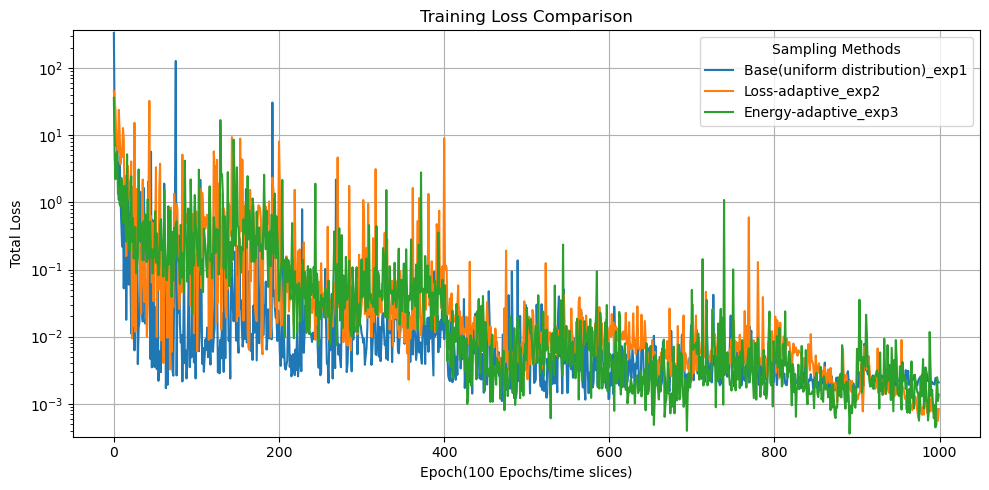

In [21]:
import matplotlib.pyplot as plt

# List of loss files
loss_file_paths = [
    "Base_g4/epsilon.txt",
    "Loss_adaptive_g4/epsilon.txt",
    "Energy_adaptive_g4/8_7_18h_epsilon.txt"
]
legend_labels = [
    "Base(uniform distribution)_exp1",
    "Loss-adaptive_exp2",
    "Energy-adaptive_exp3"
]
use_log_scale = True  # Apply log scale to Y-axis

all_loss_values = []

plt.figure(figsize=(10, 5))

for file_path, label in zip(loss_file_paths, legend_labels):
    with open(file_path, "r") as file:
        loss_values = [float(line.strip()) for line in file if line.strip()]
    
    epochs = list(range(len(loss_values)))
    all_loss_values.extend(loss_values)
    
    plt.plot(epochs, loss_values, linewidth=1.5, label=label)

plt.xlabel("Epoch(100 Epochs/time slices)")
plt.ylabel("Total Loss")
plt.title("Training Loss Comparison")
plt.grid(True)

plt.ylim(min(all_loss_values) * 0.9, max(all_loss_values) * 1.1)

if use_log_scale:
    plt.yscale("log")

plt.legend(title="Sampling Methods")
plt.tight_layout()
plt.savefig("loss_comparison.png")
plt.show()


In [29]:
import pandas as pd

sampled_u = sampled_u.reshape(-1,1)
error = []
# Compute errors
for u in u_predict:
    u = u.reshape(-1,1)
    ab_error = np.mean(np.abs(u - sampled_u))
    #print(f'\n*************** Errors of u *************** \n\n1. absolute : {ab_error}\n')
    ab_error_r = np.mean(np.abs(u - sampled_u))/np.mean(np.abs(sampled_u))
    #print(f'   relative absolute : {ab_error_r}\n\n')
    
    l2_error = np.mean((u - sampled_u)**2)**.5
    #print(f'2. L2 : {l2_error}\n')
    l2_error_r = (np.sum((u - sampled_u)**2))**.5/(np.sum(sampled_u**2))**.5
    #print(f'   relative L2 : {l2_error_r}\n\n')
    error.append([ab_error, ab_error_r, l2_error, l2_error_r])
# Create 3x4 table
#data = np.arange(1, 13).reshape(3, 4)
columns = [f'absolute', f'  relative absolute  ', f'  L2', f'  relative L2']
rows = ['Exp1_Base', 'Exp2_Loss-adaptive', 'Exp3_Energy-adaptive']
df = pd.DataFrame(error, columns=columns, index=rows)

print(df)


                      absolute    relative absolute          L2    relative L2
Exp1_Base             0.010148               0.018267  0.046702       0.069645
Exp2_Loss-adaptive    0.006332               0.011399  0.015249       0.022741
Exp3_Energy-adaptive  0.001507               0.002713  0.003320       0.004950


### Reference

[1] Wight, C. L. & Zhao, J., Solving allen-cahn and cahn-hilliard equations using the adaptive physics in-
formed neural networks, Communications in Computational Physics 29 (3) (2020).  
[2] Steve Brooks, Andrew Gelman, Galin Jones, and Xiao-Li Meng (eds.). *Handbook of Markov Chain Monte Carlo*. Chapman & Hall/CRC, 2011.


